# implement iterative identification of Ly$\alpha$ absorption

In [1]:
import os
import pickle
import numpy as np

import torch

In [2]:
from spenderq import util, load_model
from spenderq import lyalpha as LyA

In [3]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [4]:
print("torch.cuda.device_count():",torch.cuda.device_count())

torch.cuda.device_count(): 0


/home/chhahn/.conda/envs/gqp/lib/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
models, losses = load_model('/tigress/chhahn/spender_qso/models/qso.london.z_2p1_3p5.pt')

/home/chhahn/projects/SpenderQ/src/spenderq/__init__.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_struct = torch.load(filename, map_location=device)


In [6]:
ibatch = 0 
with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.pkl' % ibatch, "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)

In [7]:
true_cont = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.true_cont.npy' % (ibatch))

In [8]:
with torch.no_grad():
    models[0].eval()

    s = models[0].encode(spec)
    spec_rest = models[0].decode(s)

# 0. check out preformance for far

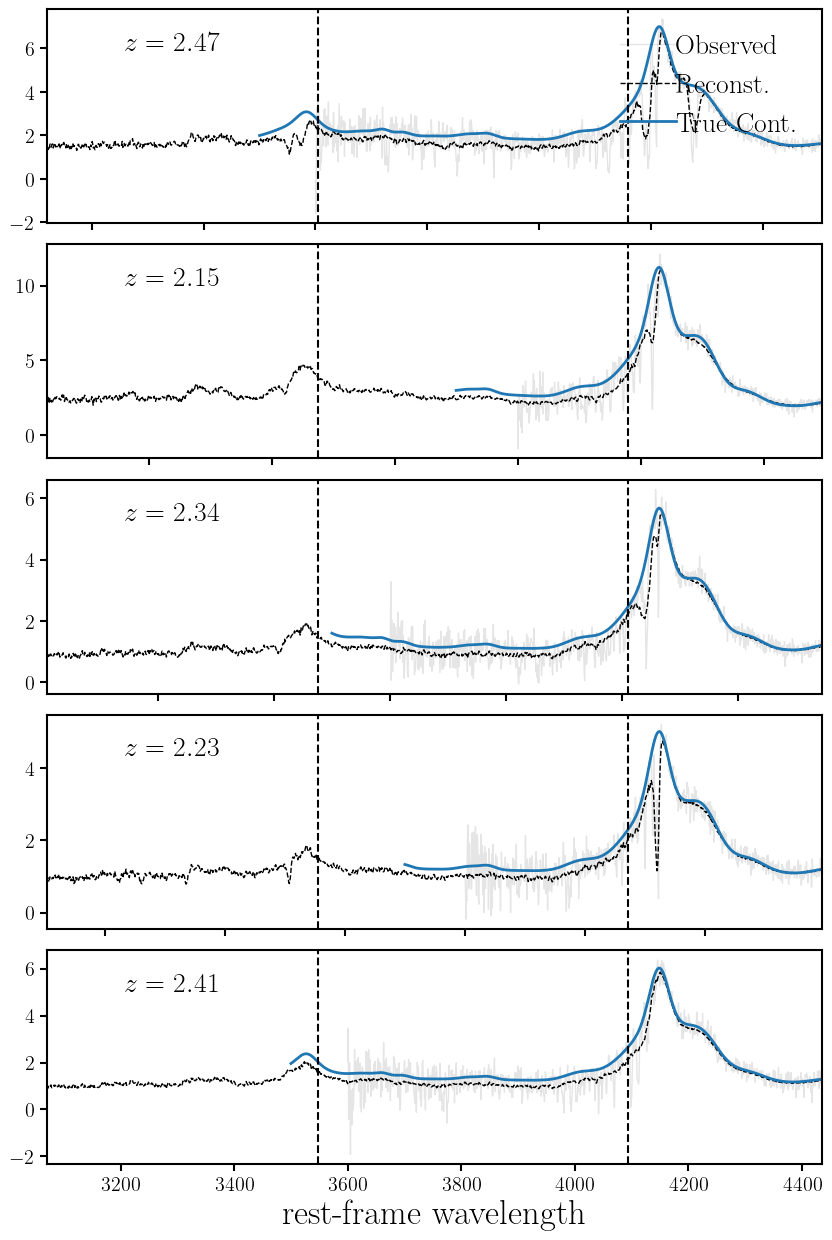

In [9]:
fig = plt.figure(figsize=(10,15))
for ii, igal in enumerate(np.random.choice(np.arange(len(spec))[np.array(norm) > 4.], size=5, replace=False)): 
    sub = fig.add_subplot(5,1,ii+1)
    sub.plot(models[0].wave_obs[w[igal] > 0], spec[igal][w[igal] > 0], c='k', alpha=0.1, lw=1, label='Observed')    
    sub.plot(models[0].wave_rest * (1 + z[igal]), spec_rest[igal], color='k', lw=1, ls='--', label='Reconst.')
    sub.plot(np.linspace(3.5e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Cont.')
    
    #sub.plot(models[0].wave_obs[(w[igal] > 0) & ~is_absorb], spec[igal][(w[igal] > 0) & ~is_absorb], c='k', alpha=0.5, lw=1, label='Observed')    
    #sub.scatter(models[0].wave_obs[is_absorb], spec[igal][is_absorb], c='r')
    
    sub.axvline(1040. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1200. * (1+z[igal]), linestyle='--', color='k')

    sub.text(0.1, 0.9, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=20, transform=sub.transAxes)

    sub.set_xlim(900 * (1+z[igal]), 1300. * (1+z[igal]))
    if ii < 4: sub.set_xticklabels([])
    if ii == 0: sub.legend(loc='upper right', fontsize=20, handletextpad=0)
sub.set_xlabel("rest-frame wavelength", fontsize=25)
fig.subplots_adjust(hspace=0.1)
plt.show()

# rebinning spectra

What are different ways to rebin: 
- simple SNR scaling of uniform rebinning
    - easy to implement
- variable wavelength binning to preserve total SNR in each bin
    - complicated to implement but could account for worse reconstructions near the left and right edges
- something in between where the bins are scaled based on the overal SNR trend in the spectra
    - would do something in between...

In [222]:
def wrebin_fixed(wobs, fobs, iobs, zobs, wmax=None, verbose=True):
    ''' uniform rebinning where binsize is scaled by SNR
    '''
    # scale resolution by SNR of the spectra below LyA
    # the scaling is set so that at SNR, each spectral element is 4A
    dw = 4.0
    #if verbose: print('median SNR = %.2f, dw = %.2f' % (np.median(snr[wobs < wmax]), dw))
    
    # coarse binning 
    Nbin = int(((wobs[-1] - wobs[0]) + 0.8)/dw)
    w_coarse = np.linspace(wobs[0]-0.4, wobs[-1]+0.4, Nbin)
    if verbose: print('rebinning to %i bins' % Nbin)
    return w_coarse


def wrebin_uniform(wobs, fobs, iobs, zobs, wmax=None, verbose=True):
    ''' uniform rebinning where binsize is scaled by SNR
    '''
    # number of bins based on overall snr
    snr = fobs * iobs**0.5 
    
    # scale resolution by SNR of the spectra below LyA
    # the scaling is set so that at SNR, each spectral element is 4A
    dw = np.clip(8.0 / np.median(snr[wobs < wmax]), 4.0, 16.)    
    if verbose: print('median SNR = %.2f, dw = %.2f' % (np.median(snr[wobs < wmax]), dw))
    
    # coarse binning 
    Nbin = int(((wobs[-1] - wobs[0]) + 0.8)/dw)
    w_coarse = np.linspace(wobs[0]-0.4, wobs[-1]+0.4, Nbin)
    if verbose: print('rebinning to %i bins' % Nbin)
    return w_coarse


def wrebin_linear(wobs, fobs, iobs, zobs, wmax=None, verbose=True):
    ''' rebinning where binsize decreases linearly with wavelength
    '''
    # number of bins based on overall snr
    snr = fobs * iobs**0.5 
    
    Nbin = np.clip(int(1500 * np.median(snr[wobs < wmax])), None, 1500)
    
    dw = np.linspace(10, 1, Nbin)
    dw *= (wobs[-1] - wobs[0] + 0.8) / np.sum(dw)
    dw = np.clip(dw, 4, None)
    
    dw = np.cumsum(dw)
    dw /= dw[-1]
    dw *= (wobs[-1] - wobs[0] + 0.8)
        
    w_coarse = np.repeat(wobs[0], Nbin+1)
    w_coarse[1:] += dw - 0.4
    if verbose: print('dw = %.2f - %.2f' % (np.gradient(w_coarse)[0], np.gradient(w_coarse)[-1]))
    if verbose: print('rebinning to %i bins' % Nbin)
    return w_coarse


def wrebin_equalsnr(wobs, fobs, iobs, zobs, wmax=None, verbose=True):
    # number of bins based on overall snr
    snr = fobs.clip(0., None) * iobs**0.5 
    
    Nbin = int(1500 * np.median(snr[wobs < wmax]))
    #Nbin = int(len(wobs)/np.clip(1500 * np.median(snr[wobs < wmax]), 100, 2000))

    # rebin spectral elements to have similar total snr
    isnr = np.digitize(np.cumsum(snr)/np.sum(snr), np.linspace(0., 1., Nbin)) - 1
    # get bin edges of rebinned
    uniq, iuniq = np.unique(isnr, return_index=True)
    Nbin = len(uniq)

    w_coarse = np.repeat(wobs[0]-0.4, Nbin+1)
    w_coarse[1:] +=  np.linspace(0., 1., Nbin)[isnr[iuniq]] * (wobs[-1] - wobs[0] + 0.8)
    #w_coarse[:-1] = np.linspace(wobs[0]-0.4, wobs[-1]+0.4, len(wobs)+1)[iuniq]
    if verbose: print('dw = %.2f - %.2f' % (np.gradient(w_coarse)[0], np.gradient(w_coarse)[-1]))
    
    i_coarse = np.digitize(wobs, w_coarse, right=False) - 1
    if verbose: print('rebinning to %i bins' % Nbin)
    return w_coarse
    

def rebin(wobs, fobs, iobs, zobs, wmod, fmod, method='uniform', wmax=None, verbose=True):
    if method == 'fixed': 
        w_coarse = wrebin_fixed(wobs, fobs, iobs, zobs, wmax=wmax, verbose=verbose)
    elif method == 'uniform': 
        w_coarse = wrebin_uniform(wobs, fobs, iobs, zobs, wmax=wmax, verbose=verbose)
    elif method == 'linear':
        w_coarse = wrebin_linear(wobs, fobs, iobs, zobs, wmax=wmax, verbose=verbose)
    elif method == 'equalsnr': 
        w_coarse = wrebin_equalsnr(wobs, fobs, iobs, zobs, wmax=wmax, verbose=verbose)
    else: 
        raise ValueError

    # observed flux and ivar coarse binned
    fobs_coarse = np.zeros(len(w_coarse)-1)
    iobs_coarse = np.zeros(len(w_coarse)-1)
    fobs_coarse[1:-1] = util.trapz_rebin(wobs, fobs, edges=w_coarse[1:-1])
    iobs_coarse[1:-1] = util.trapz_rebin(wobs, iobs/np.gradient(wobs), 
                                         edges=w_coarse[1:-1])

    # deal with edges (assume uniform binning for observed anad model spectra)
    wlim = (wobs < w_coarse[1])
    fobs_coarse[0] = np.sum(np.diff(wobs)[0] * fobs[wlim])/(w_coarse[1] - w_coarse[0])
    iobs_coarse[0] = np.sum(np.diff(wobs)[0] * (iobs/np.gradient(wobs))[wlim])/(w_coarse[1] - w_coarse[0])
    wlim = (wobs > w_coarse[-2])
    fobs_coarse[-1] = np.sum(np.diff(wobs)[0] * fobs[wlim])/(w_coarse[-1] - w_coarse[-2])
    iobs_coarse[-1] = np.sum(np.diff(wobs)[0] * (iobs/np.gradient(wobs))[wlim])/(w_coarse[-1] - w_coarse[-2])
    # rescale ivar
    iobs_coarse *= np.diff(w_coarse)
    
    # reconstructed flux coarse binned
    fmod_coarse = np.zeros(len(w_coarse)-1)
    fmod_coarse[1:-1] = util.trapz_rebin(wmod, fmod, edges=w_coarse[1:-1])
    
    wlim = (w_coarse[0] <= wmod) & (wmod < w_coarse[1])
    fmod_coarse[-1] = np.sum(np.diff(wmod)[0] * fmod[wlim])/(w_coarse[1] - w_coarse[0])
    wlim = (w_coarse[-2] <= wmod) & (wmod < w_coarse[-1])
    fmod_coarse[-1] = np.sum(np.diff(wmod)[0] * fmod[wlim])/(w_coarse[-1] - w_coarse[-2])
    return w_coarse, fobs_coarse, iobs_coarse, fmod_coarse

median SNR = 43.03, dw = 4.00
rebinning to 1556 bins
dw = 5.96 - 3.37
rebinning to 1500 bins


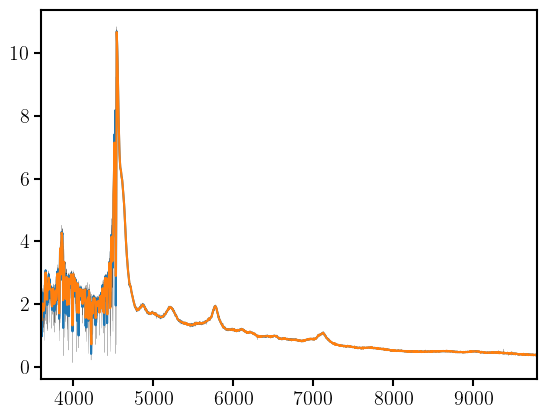

median SNR = 13.29, dw = 4.00
rebinning to 1556 bins
dw = 5.96 - 3.37
rebinning to 1500 bins


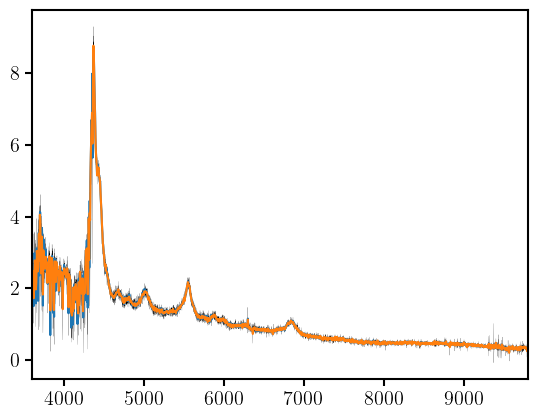

median SNR = 2.28, dw = 4.00
rebinning to 1556 bins
dw = 5.96 - 3.37
rebinning to 1500 bins


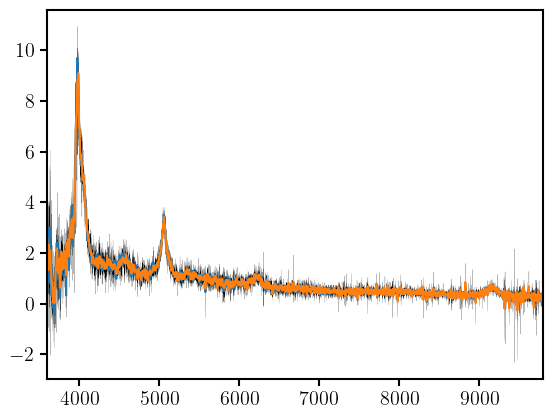

median SNR = 1.15, dw = 6.95
rebinning to 895 bins
dw = 5.96 - 3.37
rebinning to 1500 bins


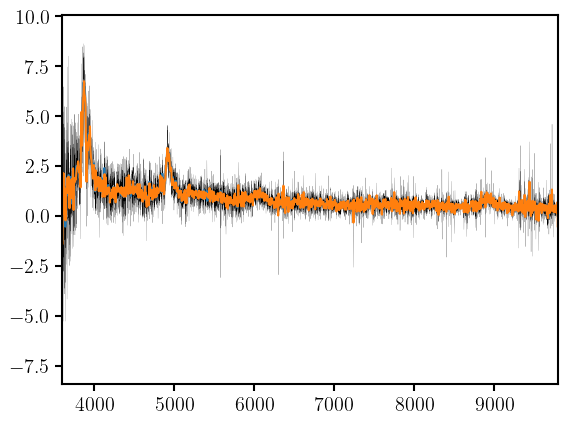

median SNR = 0.46, dw = 16.00
rebinning to 389 bins
dw = 15.61 - 3.92
rebinning to 692 bins


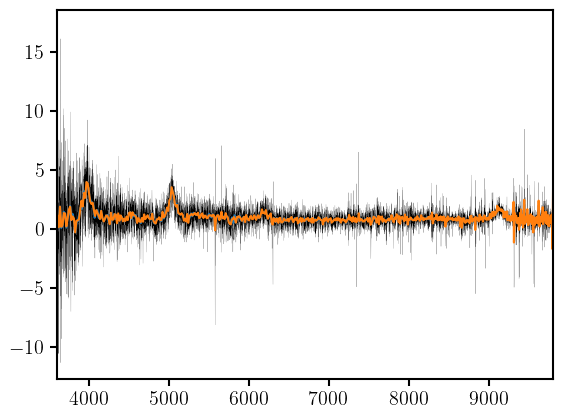

In [210]:
for ii, igal in enumerate(np.random.choice(np.arange(len(spec)), size=5, replace=False)): 
    plt.plot(models[0].wave_obs, spec[igal], c='k', lw=0.1)
    
    w_coarse, fobs_coarse, iobs_coarse, _= rebin(np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), np.array(z[igal]), 
          np.array(models[0].wave_obs), np.array(spec[igal]), wmax=1215.67 * (1. + np.array(z)[igal]), 
          method='uniform')
    plt.plot(0.5*(w_coarse[1:] + w_coarse[:-1]), fobs_coarse, c='C0')
    
    w_coarse, fobs_coarse, iobs_coarse, _= rebin(np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), np.array(z[igal]), 
          np.array(models[0].wave_obs), np.array(spec[igal]), wmax=1215.67 * (1. + np.array(z)[igal]), 
          method='linear')
    plt.plot(0.5*(w_coarse[1:] + w_coarse[:-1]), fobs_coarse, c='C1')
    
    #w_coarse, fobs_coarse, iobs_coarse, _= rebin(np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), np.array(z[igal]), 
    #      np.array(models[0].wave_obs), np.array(spec[igal]), wmax=1215.67 * (1. + np.array(z)[igal]), 
    #      method='equalsnr')
    #plt.plot(0.5*(w_coarse[1:] + w_coarse[:-1]), fobs_coarse, c='r')
        
    
    plt.xlim(3600, 9800)
    plt.show()

median SNR = 0.81, dw = 9.92
rebinning to 627 bins
dw = 8.05 - 3.61
rebinning to 1209 bins
median SNR = 0.17, dw = 16.00
rebinning to 389 bins
dw = 44.16 - 4.46
rebinning to 254 bins
median SNR = 3.55, dw = 4.00
rebinning to 1556 bins
dw = 5.96 - 3.37
rebinning to 1500 bins
median SNR = 2.03, dw = 4.00
rebinning to 1556 bins
dw = 5.96 - 3.37
rebinning to 1500 bins
median SNR = 1.42, dw = 5.65
rebinning to 1101 bins
dw = 5.96 - 3.37
rebinning to 1500 bins


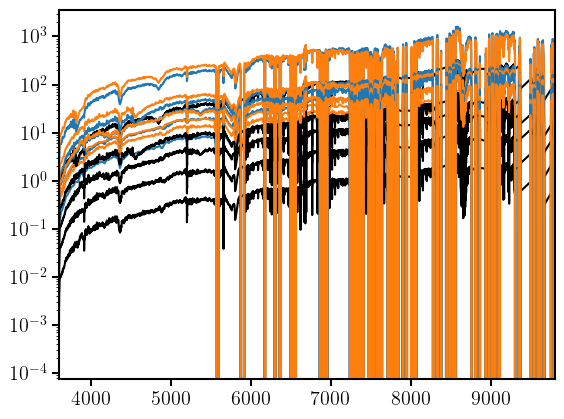

In [211]:
for ii, igal in enumerate(np.random.choice(np.arange(len(spec)), size=5, replace=False)): 
    plt.plot(models[0].wave_obs[w[igal] > 0], w[igal][w[igal] > 0], c='k')
    
    w_coarse, fobs_coarse, iobs_coarse, _= rebin(np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), np.array(z[igal]), 
          np.array(models[0].wave_obs), np.array(spec[igal]), wmax=1215.67 * (1. + np.array(z)[igal]), 
          method='uniform')
    plt.plot(0.5*(w_coarse[1:] + w_coarse[:-1]), iobs_coarse, c='C0')
    
    w_coarse, fobs_coarse, iobs_coarse, _= rebin(np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), np.array(z[igal]), 
          np.array(models[0].wave_obs), np.array(spec[igal]), wmax=1215.67 * (1. + np.array(z)[igal]), 
          method='linear')
    plt.plot(0.5*(w_coarse[1:] + w_coarse[:-1]), iobs_coarse, c='C1') 
     
    
    plt.xlim(3600, 9800)
    plt.yscale('log')

# 1. Identify LyA absorption region

In [212]:
def id_LyA_rebin(wobs, fobs, iobs, zobs, wmod, fmod, sigma=1.5, method='linear', wmax=None, verbose=False):
    ''' coarsely rebin spectrum and identify absorption wavelengths
    '''
    w_coarse, fobs_coarse, iobs_coarse, fmod_coarse = rebin(wobs, fobs, iobs, zobs, wmod, fmod, method=method, wmax=wmax, verbose=verbose)

    is_absorb_coarse = np.zeros(len(fobs_coarse)).astype(bool)
    # below LyA
    below_lya = (w_coarse[1:] < wmax) # right edge of spectral element is less wmax
    is_absorb_coarse[below_lya] = (fmod_coarse[below_lya] - fobs_coarse[below_lya] > sigma * iobs_coarse[below_lya]**-0.5)
    # above LyA (more conservative 3 sigma clipping)
    is_absorb_coarse[~below_lya] = (fmod_coarse[~below_lya] - fobs_coarse[~below_lya] > 3 * iobs_coarse[~below_lya]**-0.5)

    i_coarse = np.digitize(wobs, w_coarse, right=False) - 1
    
    is_absorb = np.zeros(len(wobs)).astype(bool)  
    is_absorb = is_absorb_coarse[i_coarse]
    return w_coarse, fobs_coarse, iobs_coarse, is_absorb

# high SNR

rebinning to 1556 bins
median SNR = 6.87, dw = 4.00
rebinning to 1556 bins
dw = 5.96 - 3.37
rebinning to 1500 bins
rebinning to 1556 bins
median SNR = 13.19, dw = 4.00
rebinning to 1556 bins
dw = 5.96 - 3.37
rebinning to 1500 bins
rebinning to 1556 bins
median SNR = 3.76, dw = 4.00
rebinning to 1556 bins


/tmp/ipykernel_2363204/2183279115.py:11: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[~below_lya] = (fmod_coarse[~below_lya] - fobs_coarse[~below_lya] > 3 * iobs_coarse[~below_lya]**-0.5)
/tmp/ipykernel_2363204/2972748042.py:12: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/2972748042.py:36: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/2972748042.py:60: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/2183279115.py:11: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[~below_lya] = (fmod_coarse[~below_lya] - fobs_coarse[~below_lya] > 3 * iobs_coarse[~below_lya]**-0.5)
/tmp/ipykernel_23632

dw = 5.96 - 3.37
rebinning to 1500 bins
rebinning to 1556 bins
median SNR = 14.34, dw = 4.00
rebinning to 1556 bins
dw = 5.96 - 3.37
rebinning to 1500 bins
rebinning to 1556 bins
median SNR = 8.10, dw = 4.00
rebinning to 1556 bins
dw = 5.96 - 3.37
rebinning to 1500 bins


/tmp/ipykernel_2363204/2972748042.py:60: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/2183279115.py:11: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[~below_lya] = (fmod_coarse[~below_lya] - fobs_coarse[~below_lya] > 3 * iobs_coarse[~below_lya]**-0.5)
/tmp/ipykernel_2363204/2972748042.py:12: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/2972748042.py:36: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/2972748042.py:60: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/2183279115.py:11: RuntimeWa

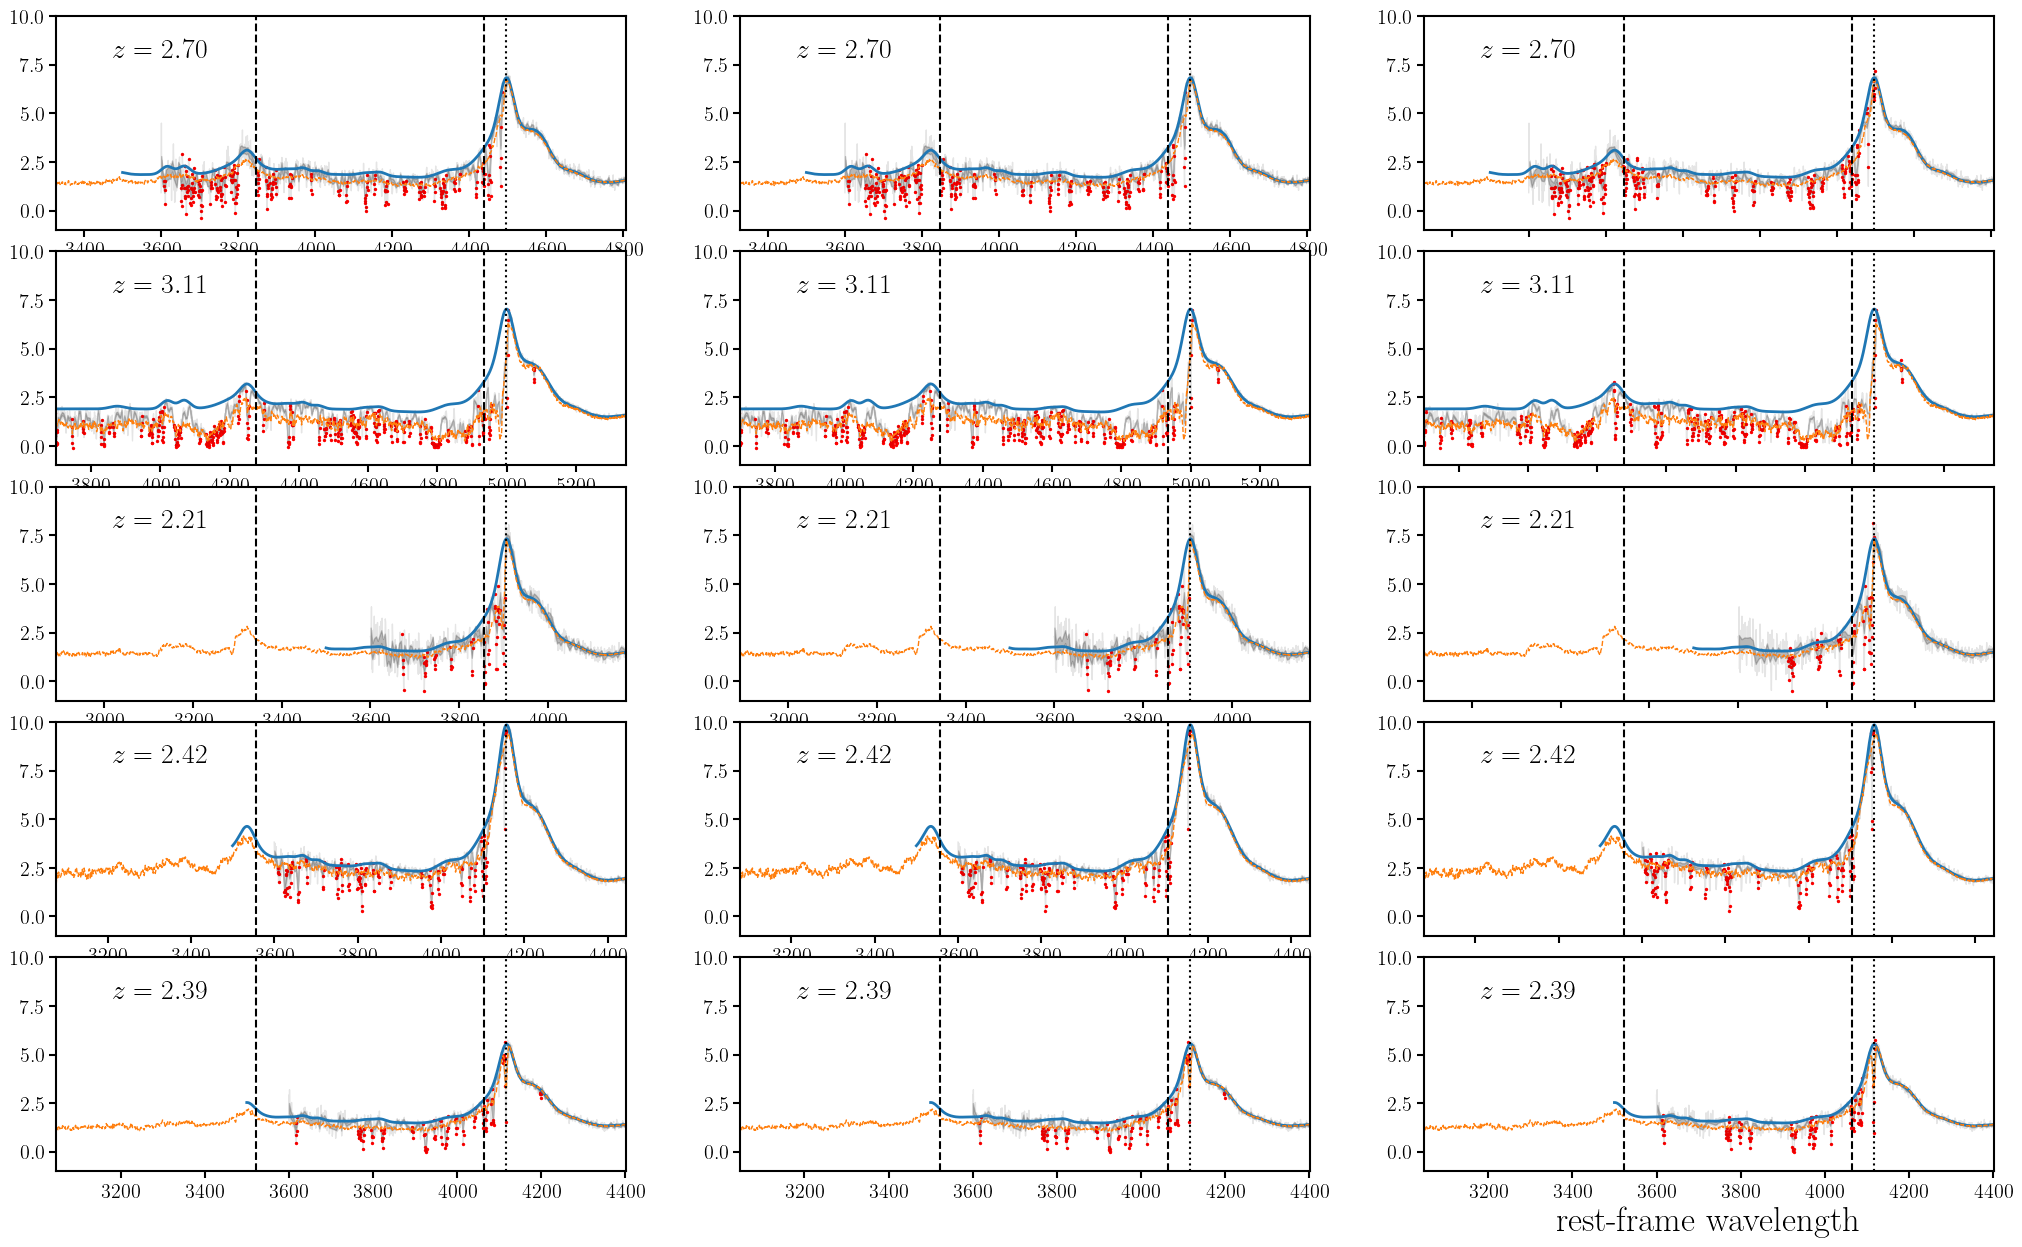

In [226]:
fig = plt.figure(figsize=(25,15))
for ii, igal in enumerate(np.random.choice(np.arange(len(spec))[np.array(norm) > 4], size=5, replace=False)): 
    sub = fig.add_subplot(5,3,3*ii+1)
    
    sub.plot(models[0].wave_obs[w[igal] > 0], spec[igal][w[igal] > 0], c='k', alpha=0.1, lw=1, label='Observed')    
    sub.plot(np.linspace(3.5e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Cont.')
    
    _w, _f, _i, is_absorb = id_LyA_rebin(
        np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), np.array(z)[igal], 
        np.array(models[0].wave_rest * (1 + z[igal])), np.array(spec_rest[igal]), wmax=1215.67 * (1. + np.array(z)[igal]), 
        method='fixed', verbose=True)
    sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
    sub.scatter(models[0].wave_obs[is_absorb], spec[igal][is_absorb], c='r', s=2)    

    sub.plot(models[0].wave_rest * (1 + z[igal]), spec_rest[igal], color='C1', lw=1, ls='--', label='Reconst.')

    
    sub.axvline(1040. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1200. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1215.67 * (1+z[igal]), linestyle=':', color='k')    

    sub.text(0.1, 0.9, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=20, transform=sub.transAxes)
    sub.set_ylim(-1, 10)
    sub.set_xlim(900 * (1+z[igal]), 1300. * (1+z[igal]))
    
    
    sub = fig.add_subplot(5,3,3*ii+2)
    
    sub.plot(models[0].wave_obs[w[igal] > 0], spec[igal][w[igal] > 0], c='k', alpha=0.1, lw=1, label='Observed')    
    sub.plot(np.linspace(3.5e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Cont.')
    
    _w, _f, _i, is_absorb = id_LyA_rebin(
        np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), np.array(z)[igal], 
        np.array(models[0].wave_rest * (1 + z[igal])), np.array(spec_rest[igal]), wmax=1215.67 * (1. + np.array(z)[igal]), 
        method='uniform', verbose=True)
    sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
    sub.scatter(models[0].wave_obs[is_absorb], spec[igal][is_absorb], c='r', s=2)    

    sub.plot(models[0].wave_rest * (1 + z[igal]), spec_rest[igal], color='C1', lw=1, ls='--', label='Reconst.')

    
    sub.axvline(1040. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1200. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1215.67 * (1+z[igal]), linestyle=':', color='k')    

    sub.text(0.1, 0.9, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=20, transform=sub.transAxes)
    sub.set_ylim(-1, 10)
    sub.set_xlim(900 * (1+z[igal]), 1300. * (1+z[igal]))
    
    
    sub = fig.add_subplot(5,3,3*ii+3)
    sub.plot(models[0].wave_obs[w[igal] > 0], spec[igal][w[igal] > 0], c='k', alpha=0.1, lw=1, label='Observed')    
    sub.plot(np.linspace(3.5e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Cont.')

    
    _w, _f, _i, is_absorb = id_LyA_rebin(
        np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), np.array(z)[igal], 
        np.array(models[0].wave_rest * (1 + z[igal])), np.array(spec_rest[igal]), wmax=1215.67 * (1. + np.array(z)[igal]), 
        method='linear', verbose=True)
    sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
    sub.scatter(models[0].wave_obs[is_absorb], spec[igal][is_absorb], c='r', s=2)    


    sub.plot(models[0].wave_rest * (1 + z[igal]), spec_rest[igal], color='C1', lw=1, ls='--', label='Reconst.')

    
    sub.axvline(1040. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1200. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1215.67 * (1+z[igal]), linestyle=':', color='k')    

    sub.text(0.1, 0.9, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=20, transform=sub.transAxes)
    sub.set_ylim(-1, 10)
    sub.set_xlim(900 * (1+z[igal]), 1300. * (1+z[igal]))
    if ii < 4: sub.set_xticklabels([])
    #if ii == 0: sub.legend(loc='upper right', fontsize=20, handletextpad=0)
sub.set_xlabel("rest-frame wavelength", fontsize=25)
fig.subplots_adjust(hspace=0.1)
plt.show()

rebinning to 1556 bins
median SNR = 6.87, dw = 4.00
rebinning to 1556 bins
dw = 5.96 - 3.37
rebinning to 1500 bins
rebinning to 1556 bins
median SNR = 4.30, dw = 4.00
rebinning to 1556 bins


/tmp/ipykernel_2363204/2183279115.py:11: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[~below_lya] = (fmod_coarse[~below_lya] - fobs_coarse[~below_lya] > 3 * iobs_coarse[~below_lya]**-0.5)
/tmp/ipykernel_2363204/2476889265.py:12: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/2476889265.py:36: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/2476889265.py:60: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/2183279115.py:11: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[~below_lya] = (fmod_coarse[~below_lya] - fobs_coarse[~below_lya] > 3 * iobs_coarse[~below_lya]**-0.5)
/tmp/ipykernel_23632

dw = 5.96 - 3.37
rebinning to 1500 bins
rebinning to 1556 bins
median SNR = 5.04, dw = 4.00
rebinning to 1556 bins
dw = 5.96 - 3.37
rebinning to 1500 bins
rebinning to 1556 bins


/tmp/ipykernel_2363204/2476889265.py:60: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/2183279115.py:11: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[~below_lya] = (fmod_coarse[~below_lya] - fobs_coarse[~below_lya] > 3 * iobs_coarse[~below_lya]**-0.5)
/tmp/ipykernel_2363204/2476889265.py:12: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/2476889265.py:36: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/2476889265.py:60: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/2183279115.py:11: RuntimeWa

median SNR = 14.76, dw = 4.00
rebinning to 1556 bins
dw = 5.96 - 3.37
rebinning to 1500 bins
rebinning to 1556 bins
median SNR = 3.47, dw = 4.00
rebinning to 1556 bins
dw = 5.96 - 3.37
rebinning to 1500 bins


/tmp/ipykernel_2363204/2476889265.py:60: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/2183279115.py:11: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[~below_lya] = (fmod_coarse[~below_lya] - fobs_coarse[~below_lya] > 3 * iobs_coarse[~below_lya]**-0.5)
/tmp/ipykernel_2363204/2476889265.py:12: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/2476889265.py:36: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/2476889265.py:60: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)


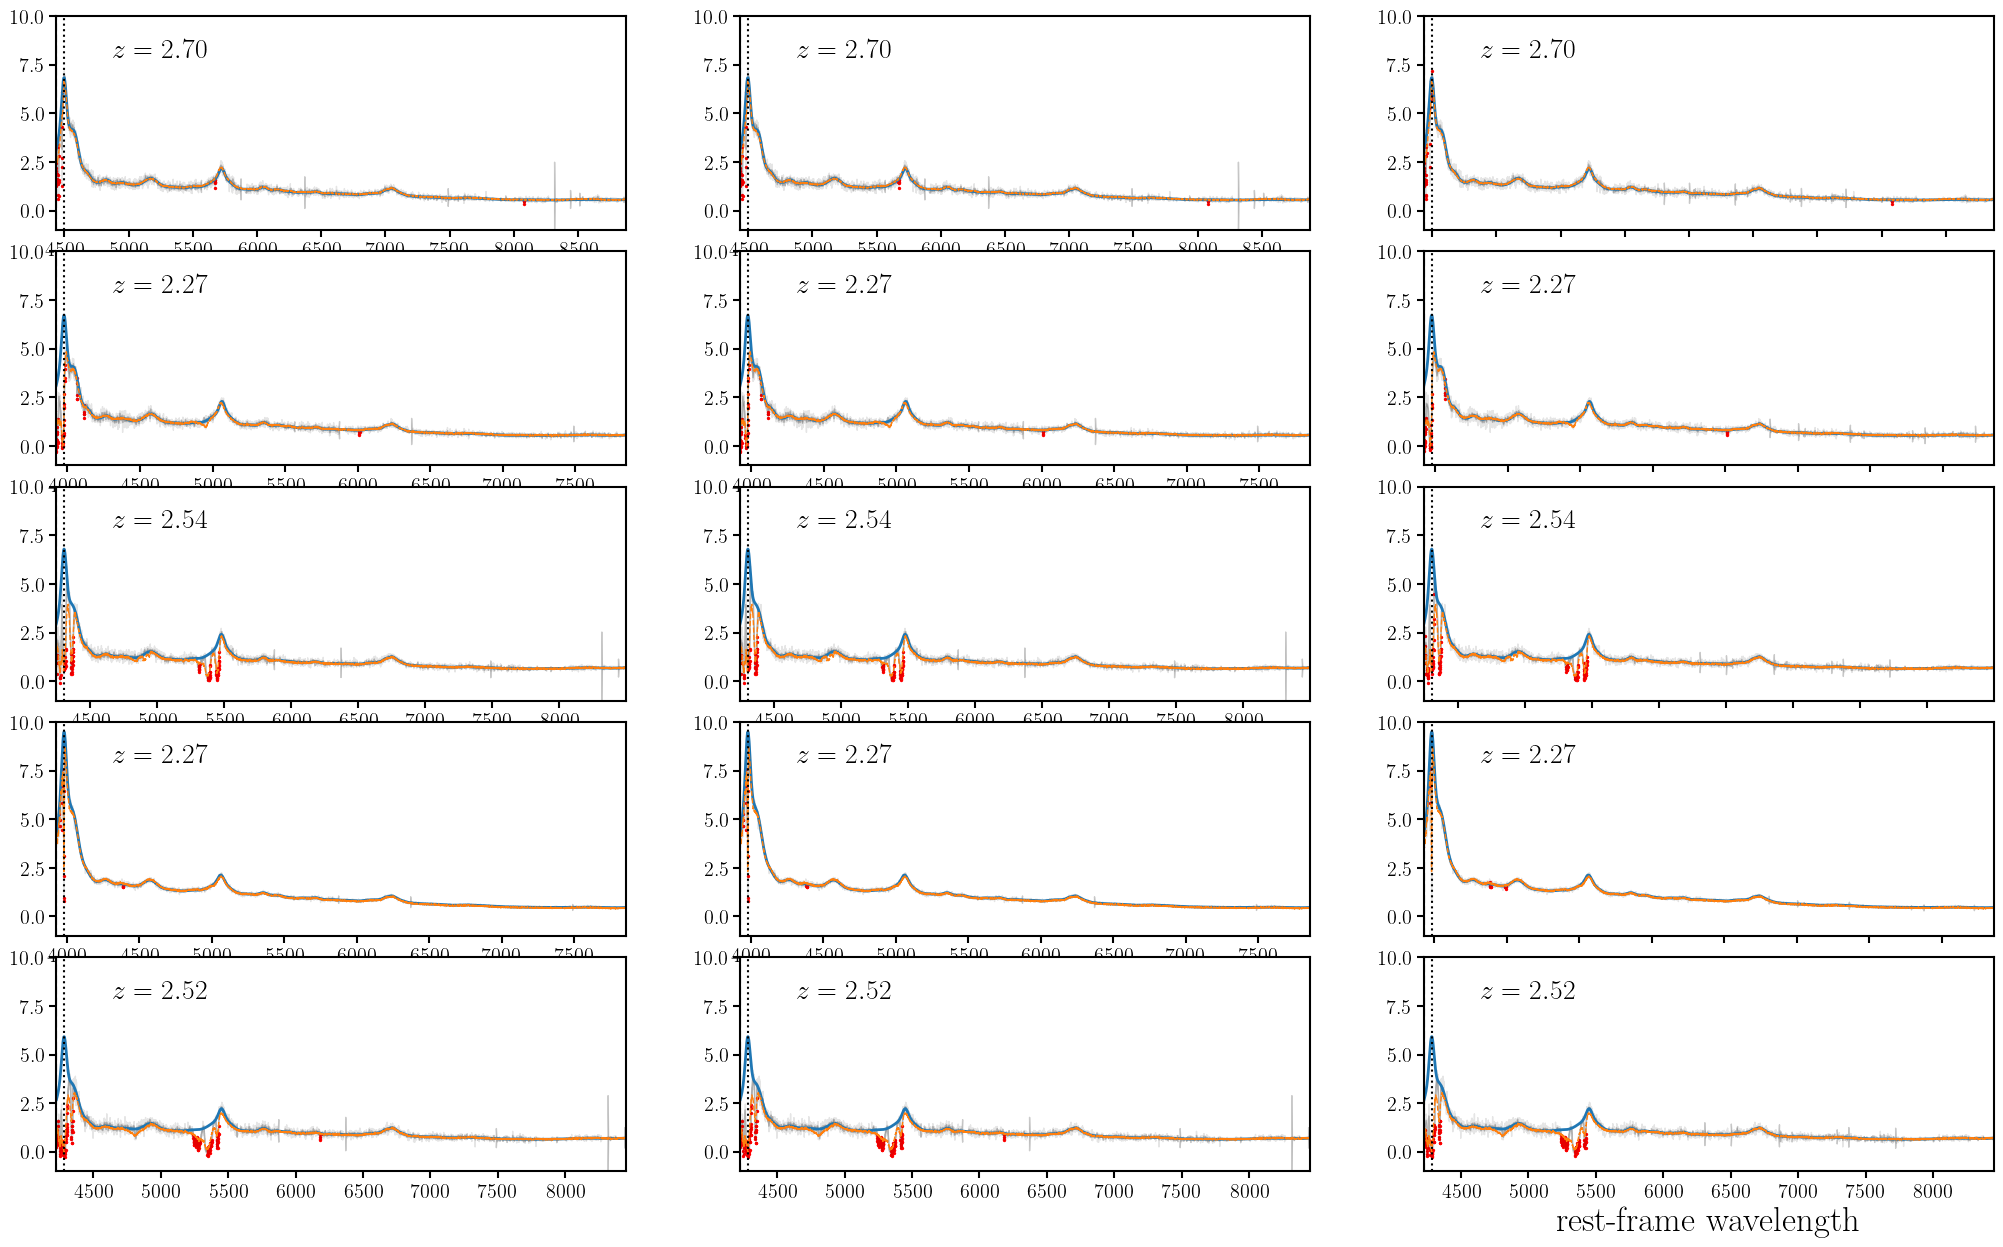

In [229]:
fig = plt.figure(figsize=(25,15))
for ii, igal in enumerate(np.random.choice(np.arange(len(spec))[np.array(norm) > 4], size=5, replace=False)): 
    sub = fig.add_subplot(5,3,3*ii+1)
    
    sub.plot(models[0].wave_obs[w[igal] > 0], spec[igal][w[igal] > 0], c='k', alpha=0.1, lw=1, label='Observed')    
    sub.plot(np.linspace(3.5e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Cont.')
    
    _w, _f, _i, is_absorb = id_LyA_rebin(
        np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), np.array(z)[igal], 
        np.array(models[0].wave_rest * (1 + z[igal])), np.array(spec_rest[igal]), wmax=1215.67 * (1. + np.array(z)[igal]), 
        method='fixed', verbose=True)
    sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
    sub.scatter(models[0].wave_obs[is_absorb], spec[igal][is_absorb], c='r', s=2)    

    sub.plot(models[0].wave_rest * (1 + z[igal]), spec_rest[igal], color='C1', lw=1, ls='--', label='Reconst.')

    
    sub.axvline(1040. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1200. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1215.67 * (1+z[igal]), linestyle=':', color='k')    

    sub.text(0.1, 0.9, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=20, transform=sub.transAxes)
    sub.set_ylim(-1, 10)
    sub.set_xlim(1200 * (1+z[igal]), 2400. * (1+z[igal]))
    
    
    sub = fig.add_subplot(5,3,3*ii+2)
    
    sub.plot(models[0].wave_obs[w[igal] > 0], spec[igal][w[igal] > 0], c='k', alpha=0.1, lw=1, label='Observed')    
    sub.plot(np.linspace(3.5e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Cont.')
    
    _w, _f, _i, is_absorb = id_LyA_rebin(
        np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), np.array(z)[igal], 
        np.array(models[0].wave_rest * (1 + z[igal])), np.array(spec_rest[igal]), wmax=1215.67 * (1. + np.array(z)[igal]), 
        method='uniform', verbose=True)
    sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
    sub.scatter(models[0].wave_obs[is_absorb], spec[igal][is_absorb], c='r', s=2)    

    sub.plot(models[0].wave_rest * (1 + z[igal]), spec_rest[igal], color='C1', lw=1, ls='--', label='Reconst.')

    
    sub.axvline(1040. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1200. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1215.67 * (1+z[igal]), linestyle=':', color='k')    

    sub.text(0.1, 0.9, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=20, transform=sub.transAxes)
    sub.set_ylim(-1, 10)
    sub.set_xlim(1200 * (1+z[igal]), 2400. * (1+z[igal]))
    
    
    sub = fig.add_subplot(5,3,3*ii+3)
    sub.plot(models[0].wave_obs[w[igal] > 0], spec[igal][w[igal] > 0], c='k', alpha=0.1, lw=1, label='Observed')    
    sub.plot(np.linspace(3.5e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Cont.')

    
    _w, _f, _i, is_absorb = id_LyA_rebin(
        np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), np.array(z)[igal], 
        np.array(models[0].wave_rest * (1 + z[igal])), np.array(spec_rest[igal]), wmax=1215.67 * (1. + np.array(z)[igal]), 
        method='linear', verbose=True)
    sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
    sub.scatter(models[0].wave_obs[is_absorb], spec[igal][is_absorb], c='r', s=2)    


    sub.plot(models[0].wave_rest * (1 + z[igal]), spec_rest[igal], color='C1', lw=1, ls='--', label='Reconst.')

    
    sub.axvline(1040. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1200. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1215.67 * (1+z[igal]), linestyle=':', color='k')    

    sub.text(0.1, 0.9, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=20, transform=sub.transAxes)
    sub.set_ylim(-1, 10)
    sub.set_xlim(1200 * (1+z[igal]), 2400. * (1+z[igal]))
    if ii < 4: sub.set_xticklabels([])
    #if ii == 0: sub.legend(loc='upper right', fontsize=20, handletextpad=0)
sub.set_xlabel("rest-frame wavelength", fontsize=25)
fig.subplots_adjust(hspace=0.1)
plt.show()

# low SNR

rebinning to 1556 bins
median SNR = 0.57, dw = 14.05
rebinning to 443 bins
dw = 12.33 - 3.84
rebinning to 854 bins
rebinning to 1556 bins
median SNR = 1.08, dw = 7.43
rebinning to 838 bins
dw = 5.96 - 3.37
rebinning to 1500 bins


/tmp/ipykernel_2363204/2183279115.py:11: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[~below_lya] = (fmod_coarse[~below_lya] - fobs_coarse[~below_lya] > 3 * iobs_coarse[~below_lya]**-0.5)
/tmp/ipykernel_2363204/485445459.py:12: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/485445459.py:36: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/485445459.py:60: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/2183279115.py:11: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[~below_lya] = (fmod_coarse[~below_lya] - fobs_coarse[~below_lya] > 3 * iobs_coarse[~below_lya]**-0.5)
/tmp/ipykernel_2363204/

rebinning to 1556 bins
median SNR = 0.55, dw = 14.44
rebinning to 431 bins
dw = 12.74 - 3.85
rebinning to 830 bins
rebinning to 1556 bins
median SNR = 0.69, dw = 11.66
rebinning to 533 bins
dw = 9.89 - 3.74
rebinning to 1028 bins
rebinning to 1556 bins
median SNR = 0.53, dw = 15.00
rebinning to 414 bins
dw = 13.30 - 3.87
rebinning to 799 bins


/tmp/ipykernel_2363204/2183279115.py:11: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[~below_lya] = (fmod_coarse[~below_lya] - fobs_coarse[~below_lya] > 3 * iobs_coarse[~below_lya]**-0.5)
/tmp/ipykernel_2363204/485445459.py:12: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/485445459.py:36: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/485445459.py:60: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/2183279115.py:11: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[~below_lya] = (fmod_coarse[~below_lya] - fobs_coarse[~below_lya] > 3 * iobs_coarse[~below_lya]**-0.5)
/tmp/ipykernel_2363204/

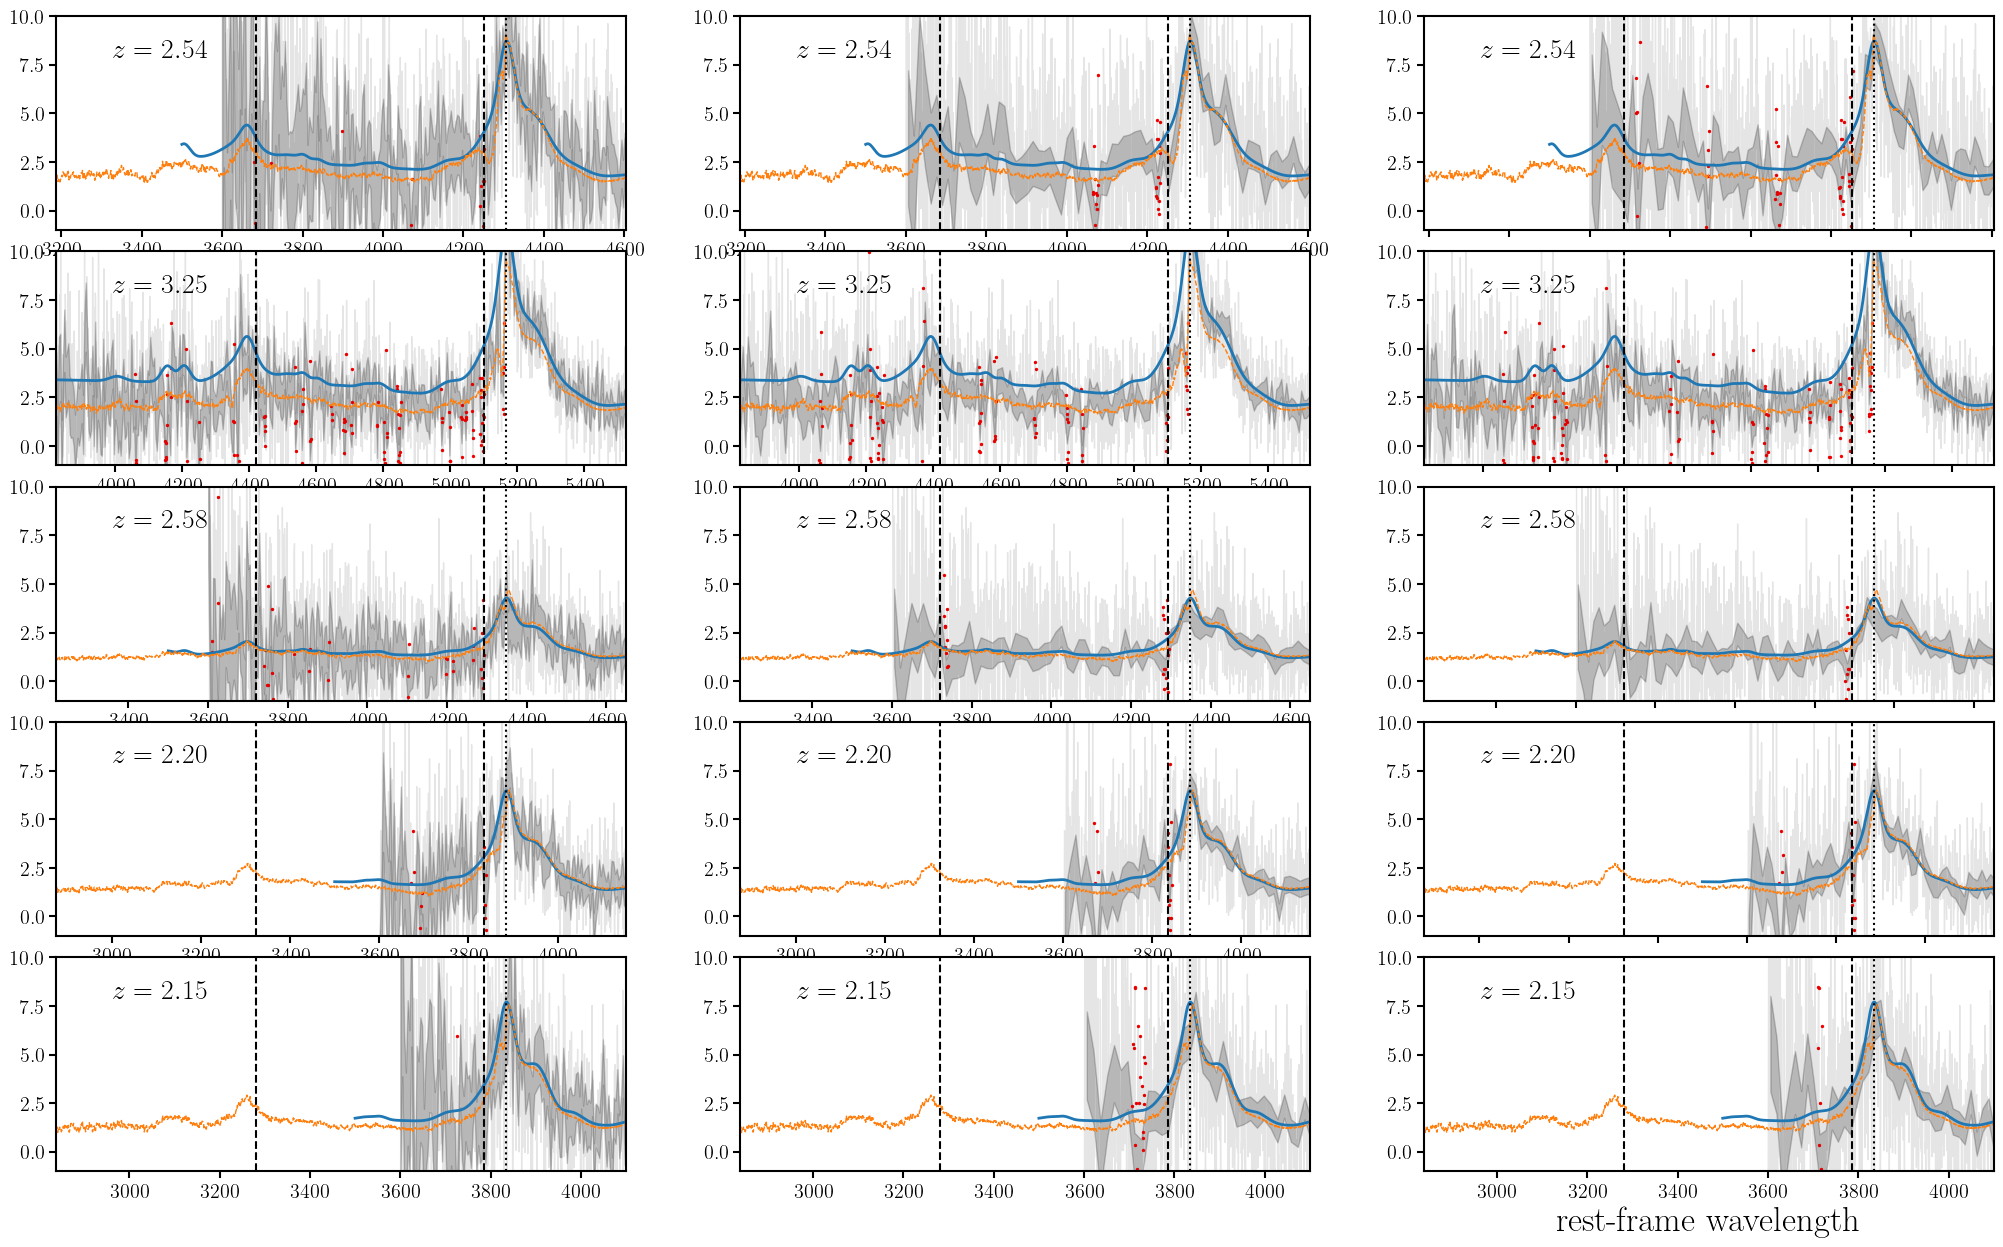

In [227]:
fig = plt.figure(figsize=(25,15))
for ii, igal in enumerate(np.random.choice(np.arange(len(spec))[np.array(norm) < 0.5], size=5, replace=False)): 
    sub = fig.add_subplot(5,3,3*ii+1)
    
    sub.plot(models[0].wave_obs[w[igal] > 0], spec[igal][w[igal] > 0], c='k', alpha=0.1, lw=1, label='Observed')    
    sub.plot(np.linspace(3.5e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Cont.')
    
    _w, _f, _i, is_absorb = id_LyA_rebin(
        np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), np.array(z)[igal], 
        np.array(models[0].wave_rest * (1 + z[igal])), np.array(spec_rest[igal]), wmax=1215.67 * (1. + np.array(z)[igal]), 
        method='fixed', verbose=True)
    sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
    sub.scatter(models[0].wave_obs[is_absorb], spec[igal][is_absorb], c='r', s=2)    

    sub.plot(models[0].wave_rest * (1 + z[igal]), spec_rest[igal], color='C1', lw=1, ls='--', label='Reconst.')

    
    sub.axvline(1040. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1200. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1215.67 * (1+z[igal]), linestyle=':', color='k')    

    sub.text(0.1, 0.9, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=20, transform=sub.transAxes)
    sub.set_ylim(-1, 10)
    sub.set_xlim(900 * (1+z[igal]), 1300. * (1+z[igal]))
    
    
    sub = fig.add_subplot(5,3,3*ii+2)
    
    sub.plot(models[0].wave_obs[w[igal] > 0], spec[igal][w[igal] > 0], c='k', alpha=0.1, lw=1, label='Observed')    
    sub.plot(np.linspace(3.5e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Cont.')
    
    _w, _f, _i, is_absorb = id_LyA_rebin(
        np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), np.array(z)[igal], 
        np.array(models[0].wave_rest * (1 + z[igal])), np.array(spec_rest[igal]), wmax=1215.67 * (1. + np.array(z)[igal]), 
        method='uniform', verbose=True)
    sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
    sub.scatter(models[0].wave_obs[is_absorb], spec[igal][is_absorb], c='r', s=2)    

    sub.plot(models[0].wave_rest * (1 + z[igal]), spec_rest[igal], color='C1', lw=1, ls='--', label='Reconst.')

    
    sub.axvline(1040. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1200. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1215.67 * (1+z[igal]), linestyle=':', color='k')    

    sub.text(0.1, 0.9, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=20, transform=sub.transAxes)
    sub.set_ylim(-1, 10)
    sub.set_xlim(900 * (1+z[igal]), 1300. * (1+z[igal]))
    
    
    sub = fig.add_subplot(5,3,3*ii+3)
    sub.plot(models[0].wave_obs[w[igal] > 0], spec[igal][w[igal] > 0], c='k', alpha=0.1, lw=1, label='Observed')    
    sub.plot(np.linspace(3.5e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Cont.')

    
    _w, _f, _i, is_absorb = id_LyA_rebin(
        np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), np.array(z)[igal], 
        np.array(models[0].wave_rest * (1 + z[igal])), np.array(spec_rest[igal]), wmax=1215.67 * (1. + np.array(z)[igal]), 
        method='linear', verbose=True)
    sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
    sub.scatter(models[0].wave_obs[is_absorb], spec[igal][is_absorb], c='r', s=2)    


    sub.plot(models[0].wave_rest * (1 + z[igal]), spec_rest[igal], color='C1', lw=1, ls='--', label='Reconst.')

    
    sub.axvline(1040. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1200. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1215.67 * (1+z[igal]), linestyle=':', color='k')    

    sub.text(0.1, 0.9, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=20, transform=sub.transAxes)
    sub.set_ylim(-1, 10)
    sub.set_xlim(900 * (1+z[igal]), 1300. * (1+z[igal]))
    if ii < 4: sub.set_xticklabels([])
    #if ii == 0: sub.legend(loc='upper right', fontsize=20, handletextpad=0)
sub.set_xlabel("rest-frame wavelength", fontsize=25)
fig.subplots_adjust(hspace=0.1)
plt.show()

rebinning to 1556 bins
median SNR = 0.22, dw = 16.00
rebinning to 389 bins
dw = 34.52 - 4.00
rebinning to 324 bins
rebinning to 1556 bins
median SNR = 0.60, dw = 13.34
rebinning to 466 bins
dw = 11.61 - 3.82
rebinning to 899 bins


/tmp/ipykernel_2363204/2183279115.py:11: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[~below_lya] = (fmod_coarse[~below_lya] - fobs_coarse[~below_lya] > 3 * iobs_coarse[~below_lya]**-0.5)
/tmp/ipykernel_2363204/424178636.py:12: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/424178636.py:36: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/424178636.py:60: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/2183279115.py:11: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[~below_lya] = (fmod_coarse[~below_lya] - fobs_coarse[~below_lya] > 3 * iobs_coarse[~below_lya]**-0.5)
/tmp/ipykernel_2363204/

rebinning to 1556 bins
median SNR = 0.21, dw = 16.00
rebinning to 389 bins
dw = 35.99 - 4.00
rebinning to 311 bins


/tmp/ipykernel_2363204/2183279115.py:11: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[~below_lya] = (fmod_coarse[~below_lya] - fobs_coarse[~below_lya] > 3 * iobs_coarse[~below_lya]**-0.5)
/tmp/ipykernel_2363204/424178636.py:12: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/424178636.py:36: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/424178636.py:60: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)


rebinning to 1556 bins
median SNR = 0.43, dw = 16.00
rebinning to 389 bins
dw = 16.83 - 3.93
rebinning to 646 bins
rebinning to 1556 bins
median SNR = 0.36, dw = 16.00
rebinning to 389 bins
dw = 20.58 - 3.97
rebinning to 535 bins


/tmp/ipykernel_2363204/2183279115.py:11: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[~below_lya] = (fmod_coarse[~below_lya] - fobs_coarse[~below_lya] > 3 * iobs_coarse[~below_lya]**-0.5)
/tmp/ipykernel_2363204/424178636.py:12: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/424178636.py:36: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/424178636.py:60: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/2183279115.py:11: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[~below_lya] = (fmod_coarse[~below_lya] - fobs_coarse[~below_lya] > 3 * iobs_coarse[~below_lya]**-0.5)
/tmp/ipykernel_2363204/

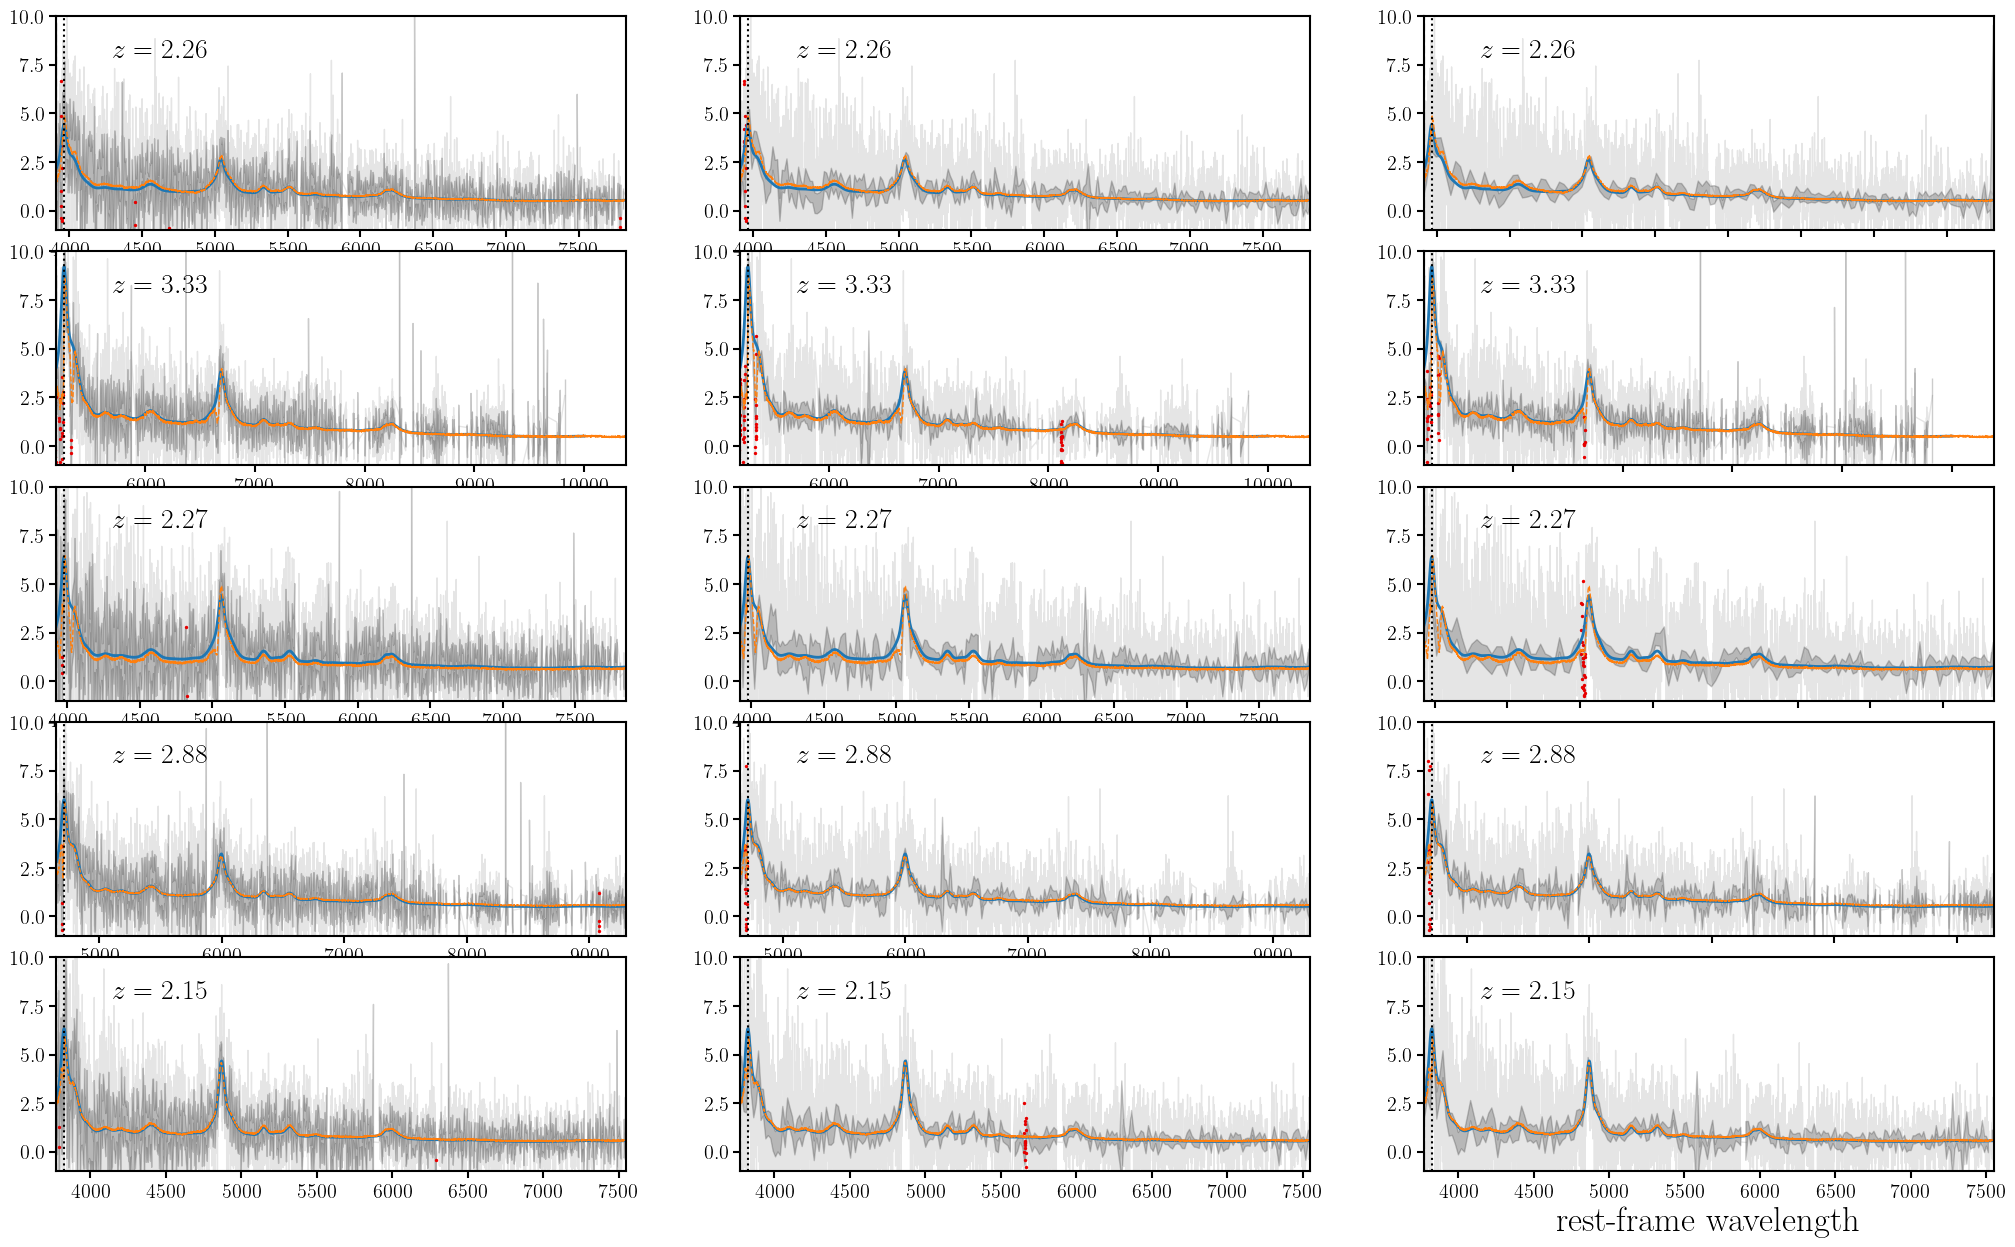

In [228]:
fig = plt.figure(figsize=(25,15))
for ii, igal in enumerate(np.random.choice(np.arange(len(spec))[np.array(norm) < 0.5], size=5, replace=False)): 
    sub = fig.add_subplot(5,3,3*ii+1)
    
    sub.plot(models[0].wave_obs[w[igal] > 0], spec[igal][w[igal] > 0], c='k', alpha=0.1, lw=1, label='Observed')    
    sub.plot(np.linspace(3.5e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Cont.')
    
    _w, _f, _i, is_absorb = id_LyA_rebin(
        np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), np.array(z)[igal], 
        np.array(models[0].wave_rest * (1 + z[igal])), np.array(spec_rest[igal]), wmax=1215.67 * (1. + np.array(z)[igal]), 
        method='fixed', verbose=True)
    sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
    sub.scatter(models[0].wave_obs[is_absorb], spec[igal][is_absorb], c='r', s=2)    

    sub.plot(models[0].wave_rest * (1 + z[igal]), spec_rest[igal], color='C1', lw=1, ls='--', label='Reconst.')

    
    sub.axvline(1040. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1200. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1215.67 * (1+z[igal]), linestyle=':', color='k')    

    sub.text(0.1, 0.9, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=20, transform=sub.transAxes)
    sub.set_ylim(-1, 10)
    sub.set_xlim(1200 * (1+z[igal]), 2400. * (1+z[igal]))
    
    
    sub = fig.add_subplot(5,3,3*ii+2)
    
    sub.plot(models[0].wave_obs[w[igal] > 0], spec[igal][w[igal] > 0], c='k', alpha=0.1, lw=1, label='Observed')    
    sub.plot(np.linspace(3.5e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Cont.')
    
    _w, _f, _i, is_absorb = id_LyA_rebin(
        np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), np.array(z)[igal], 
        np.array(models[0].wave_rest * (1 + z[igal])), np.array(spec_rest[igal]), wmax=1215.67 * (1. + np.array(z)[igal]), 
        method='uniform', verbose=True)
    sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
    sub.scatter(models[0].wave_obs[is_absorb], spec[igal][is_absorb], c='r', s=2)    

    sub.plot(models[0].wave_rest * (1 + z[igal]), spec_rest[igal], color='C1', lw=1, ls='--', label='Reconst.')

    
    sub.axvline(1040. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1200. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1215.67 * (1+z[igal]), linestyle=':', color='k')    

    sub.text(0.1, 0.9, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=20, transform=sub.transAxes)
    sub.set_ylim(-1, 10)
    sub.set_xlim(1200 * (1+z[igal]), 2400. * (1+z[igal]))
    
    
    sub = fig.add_subplot(5,3,3*ii+3)
    sub.plot(models[0].wave_obs[w[igal] > 0], spec[igal][w[igal] > 0], c='k', alpha=0.1, lw=1, label='Observed')    
    sub.plot(np.linspace(3.5e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Cont.')

    
    _w, _f, _i, is_absorb = id_LyA_rebin(
        np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), np.array(z)[igal], 
        np.array(models[0].wave_rest * (1 + z[igal])), np.array(spec_rest[igal]), wmax=1215.67 * (1. + np.array(z)[igal]), 
        method='linear', verbose=True)
    sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
    sub.scatter(models[0].wave_obs[is_absorb], spec[igal][is_absorb], c='r', s=2)    


    sub.plot(models[0].wave_rest * (1 + z[igal]), spec_rest[igal], color='C1', lw=1, ls='--', label='Reconst.')

    
    sub.axvline(1040. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1200. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1215.67 * (1+z[igal]), linestyle=':', color='k')    

    sub.text(0.1, 0.9, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=20, transform=sub.transAxes)
    sub.set_ylim(-1, 10)
    sub.set_xlim(1200 * (1+z[igal]), 2400. * (1+z[igal]))
    if ii < 4: sub.set_xticklabels([])
    #if ii == 0: sub.legend(loc='upper right', fontsize=20, handletextpad=0)
sub.set_xlabel("rest-frame wavelength", fontsize=25)
fig.subplots_adjust(hspace=0.1)
plt.show()

rebinning to 1556 bins
median SNR = 1.41, dw = 5.68
rebinning to 1095 bins
dw = 5.96 - 3.37
rebinning to 1500 bins
rebinning to 1556 bins
median SNR = 1.46, dw = 5.47
rebinning to 1137 bins
dw = 5.96 - 3.37
rebinning to 1500 bins
rebinning to 1556 bins
median SNR = 1.09, dw = 7.36
rebinning to 845 bins
dw = 5.96 - 3.37
rebinning to 1500 bins


/tmp/ipykernel_2363204/2183279115.py:11: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[~below_lya] = (fmod_coarse[~below_lya] - fobs_coarse[~below_lya] > 3 * iobs_coarse[~below_lya]**-0.5)
/tmp/ipykernel_2363204/2751307087.py:12: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/2751307087.py:36: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/2751307087.py:60: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/2183279115.py:11: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[~below_lya] = (fmod_coarse[~below_lya] - fobs_coarse[~below_lya] > 3 * iobs_coarse[~below_lya]**-0.5)
/tmp/ipykernel_23632

rebinning to 1556 bins
median SNR = 1.53, dw = 5.24
rebinning to 1188 bins
dw = 5.96 - 3.37
rebinning to 1500 bins
rebinning to 1556 bins
median SNR = 1.31, dw = 6.12
rebinning to 1016 bins
dw = 5.96 - 3.37
rebinning to 1500 bins


/tmp/ipykernel_2363204/2183279115.py:11: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[~below_lya] = (fmod_coarse[~below_lya] - fobs_coarse[~below_lya] > 3 * iobs_coarse[~below_lya]**-0.5)
/tmp/ipykernel_2363204/2751307087.py:12: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/2751307087.py:36: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/2751307087.py:60: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/2183279115.py:11: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[~below_lya] = (fmod_coarse[~below_lya] - fobs_coarse[~below_lya] > 3 * iobs_coarse[~below_lya]**-0.5)
/tmp/ipykernel_23632

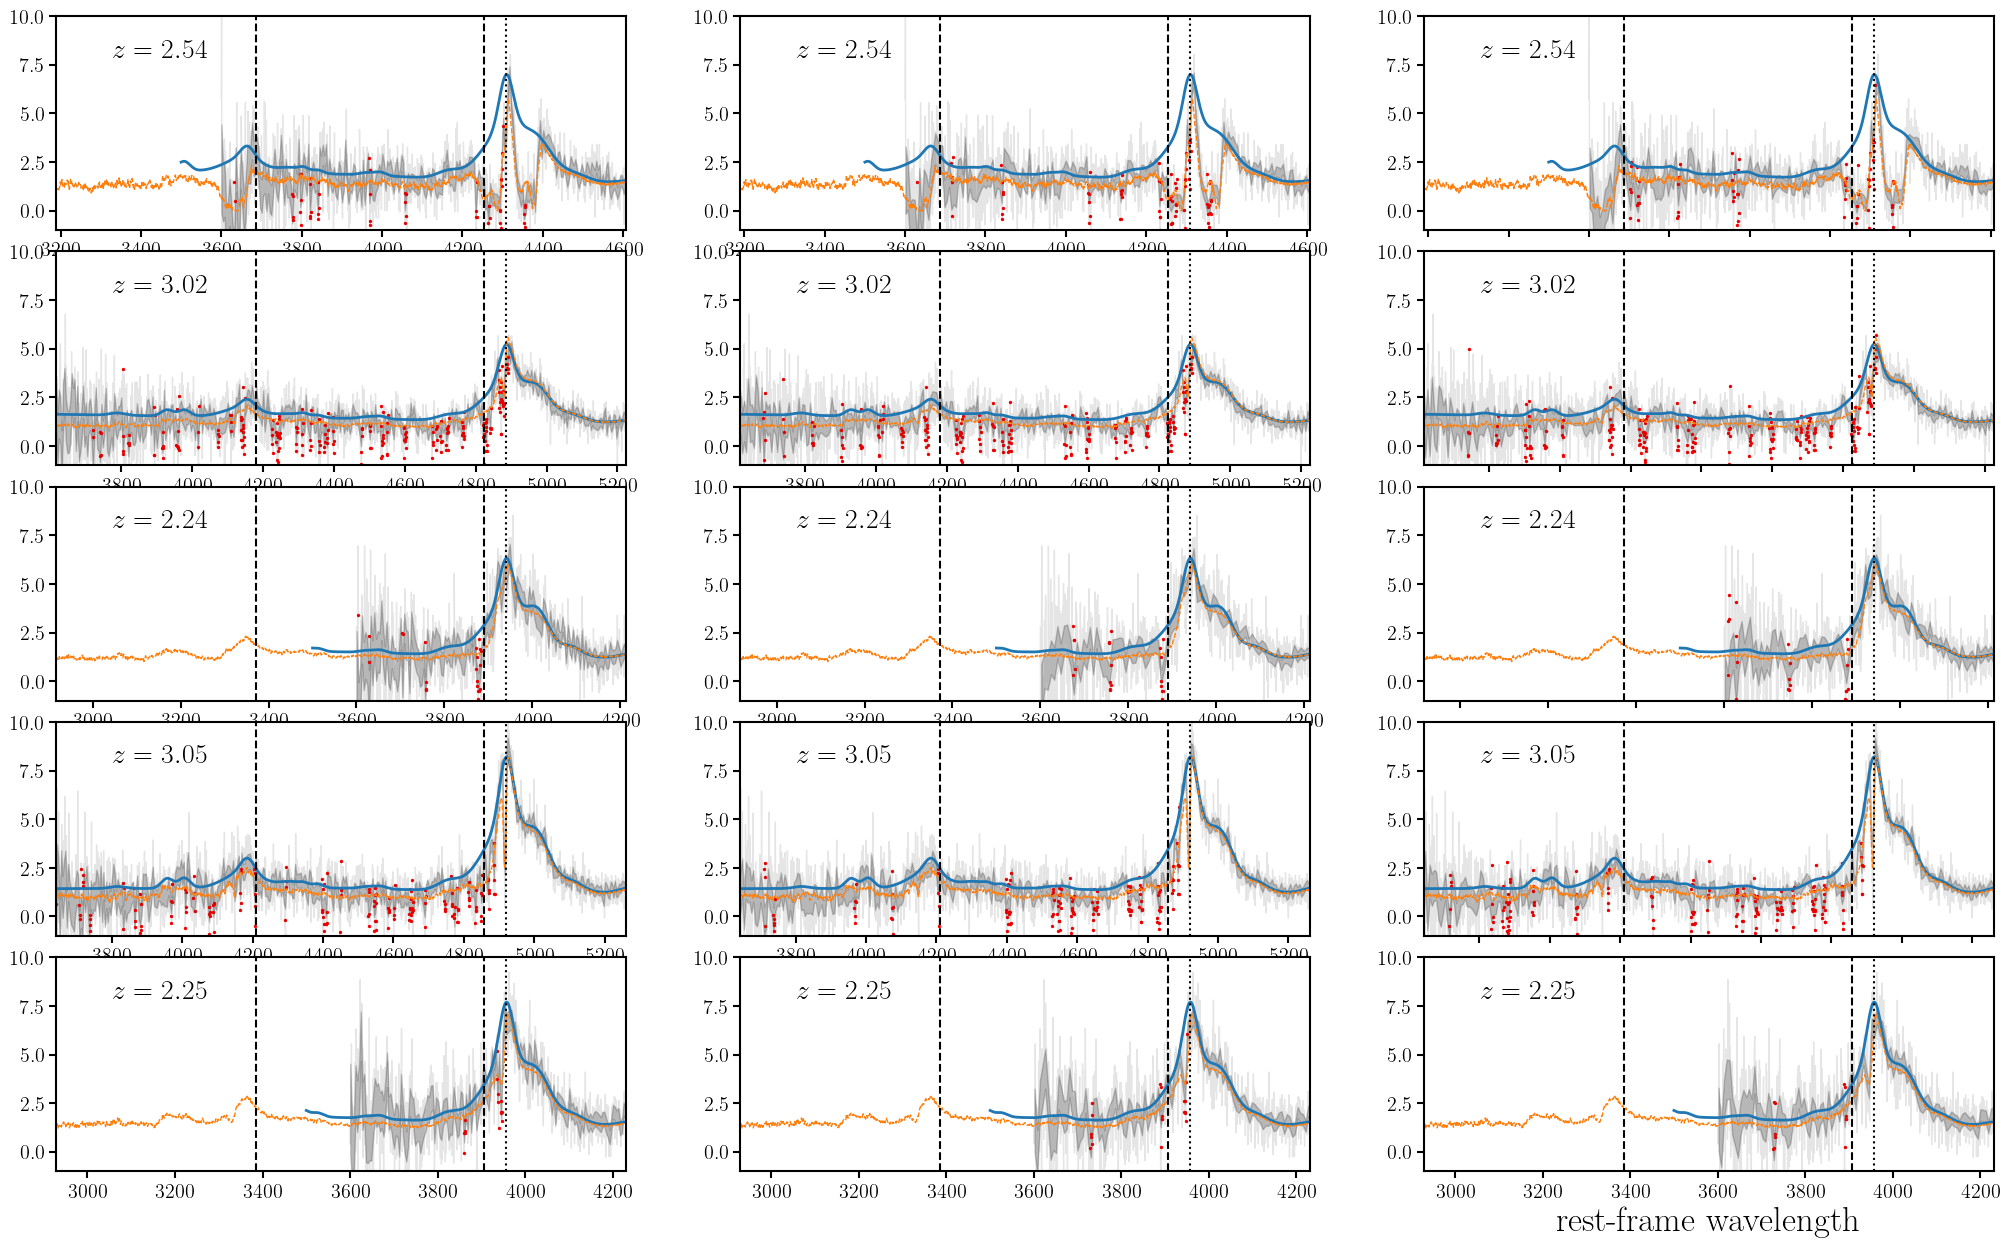

In [233]:
fig = plt.figure(figsize=(25,15))
for ii, igal in enumerate(np.random.choice(np.arange(len(spec))[np.abs(np.array(norm)-1) < 0.1], size=5, replace=False)): 
    sub = fig.add_subplot(5,3,3*ii+1)
    
    sub.plot(models[0].wave_obs[w[igal] > 0], spec[igal][w[igal] > 0], c='k', alpha=0.1, lw=1, label='Observed')    
    sub.plot(np.linspace(3.5e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Cont.')
    
    _w, _f, _i, is_absorb = id_LyA_rebin(
        np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), np.array(z)[igal], 
        np.array(models[0].wave_rest * (1 + z[igal])), np.array(spec_rest[igal]), wmax=1215.67 * (1. + np.array(z)[igal]), 
        method='fixed', verbose=True)
    sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
    sub.scatter(models[0].wave_obs[is_absorb], spec[igal][is_absorb], c='r', s=2)    

    sub.plot(models[0].wave_rest * (1 + z[igal]), spec_rest[igal], color='C1', lw=1, ls='--', label='Reconst.')

    
    sub.axvline(1040. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1200. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1215.67 * (1+z[igal]), linestyle=':', color='k')    

    sub.text(0.1, 0.9, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=20, transform=sub.transAxes)
    sub.set_ylim(-1, 10)
    sub.set_xlim(900 * (1+z[igal]), 1300. * (1+z[igal]))
    
    
    sub = fig.add_subplot(5,3,3*ii+2)
    
    sub.plot(models[0].wave_obs[w[igal] > 0], spec[igal][w[igal] > 0], c='k', alpha=0.1, lw=1, label='Observed')    
    sub.plot(np.linspace(3.5e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Cont.')
    
    _w, _f, _i, is_absorb = id_LyA_rebin(
        np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), np.array(z)[igal], 
        np.array(models[0].wave_rest * (1 + z[igal])), np.array(spec_rest[igal]), wmax=1215.67 * (1. + np.array(z)[igal]), 
        method='uniform', verbose=True)
    sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
    sub.scatter(models[0].wave_obs[is_absorb], spec[igal][is_absorb], c='r', s=2)    

    sub.plot(models[0].wave_rest * (1 + z[igal]), spec_rest[igal], color='C1', lw=1, ls='--', label='Reconst.')

    
    sub.axvline(1040. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1200. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1215.67 * (1+z[igal]), linestyle=':', color='k')    

    sub.text(0.1, 0.9, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=20, transform=sub.transAxes)
    sub.set_ylim(-1, 10)
    sub.set_xlim(900 * (1+z[igal]), 1300. * (1+z[igal]))
    
    
    sub = fig.add_subplot(5,3,3*ii+3)
    sub.plot(models[0].wave_obs[w[igal] > 0], spec[igal][w[igal] > 0], c='k', alpha=0.1, lw=1, label='Observed')    
    sub.plot(np.linspace(3.5e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Cont.')

    
    _w, _f, _i, is_absorb = id_LyA_rebin(
        np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), np.array(z)[igal], 
        np.array(models[0].wave_rest * (1 + z[igal])), np.array(spec_rest[igal]), wmax=1215.67 * (1. + np.array(z)[igal]), 
        method='linear', verbose=True)
    sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
    sub.scatter(models[0].wave_obs[is_absorb], spec[igal][is_absorb], c='r', s=2)    


    sub.plot(models[0].wave_rest * (1 + z[igal]), spec_rest[igal], color='C1', lw=1, ls='--', label='Reconst.')

    
    sub.axvline(1040. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1200. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1215.67 * (1+z[igal]), linestyle=':', color='k')    

    sub.text(0.1, 0.9, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=20, transform=sub.transAxes)
    sub.set_ylim(-1, 10)
    sub.set_xlim(900 * (1+z[igal]), 1300. * (1+z[igal]))
    if ii < 4: sub.set_xticklabels([])
    #if ii == 0: sub.legend(loc='upper right', fontsize=20, handletextpad=0)
sub.set_xlabel("rest-frame wavelength", fontsize=25)
fig.subplots_adjust(hspace=0.1)
plt.show()

rebinning to 1556 bins
median SNR = 1.12, dw = 7.13
rebinning to 872 bins
dw = 5.96 - 3.37
rebinning to 1500 bins
rebinning to 1556 bins
median SNR = 0.74, dw = 10.82
rebinning to 575 bins
dw = 9.01 - 3.68
rebinning to 1108 bins
rebinning to 1556 bins
median SNR = 1.27, dw = 6.32
rebinning to 985 bins
dw = 5.96 - 3.37
rebinning to 1500 bins
rebinning to 1556 bins
median SNR = 1.10, dw = 7.26
rebinning to 856 bins
dw = 5.96 - 3.37
rebinning to 1500 bins


/tmp/ipykernel_2363204/2183279115.py:11: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[~below_lya] = (fmod_coarse[~below_lya] - fobs_coarse[~below_lya] > 3 * iobs_coarse[~below_lya]**-0.5)
/tmp/ipykernel_2363204/4169131348.py:12: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/4169131348.py:36: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/4169131348.py:60: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/2183279115.py:11: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[~below_lya] = (fmod_coarse[~below_lya] - fobs_coarse[~below_lya] > 3 * iobs_coarse[~below_lya]**-0.5)
/tmp/ipykernel_23632

rebinning to 1556 bins
median SNR = 1.17, dw = 6.83
rebinning to 911 bins
dw = 5.96 - 3.37
rebinning to 1500 bins


/tmp/ipykernel_2363204/2183279115.py:11: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[~below_lya] = (fmod_coarse[~below_lya] - fobs_coarse[~below_lya] > 3 * iobs_coarse[~below_lya]**-0.5)
/tmp/ipykernel_2363204/4169131348.py:12: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/4169131348.py:36: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
/tmp/ipykernel_2363204/4169131348.py:60: RuntimeWarning: divide by zero encountered in power
  sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)


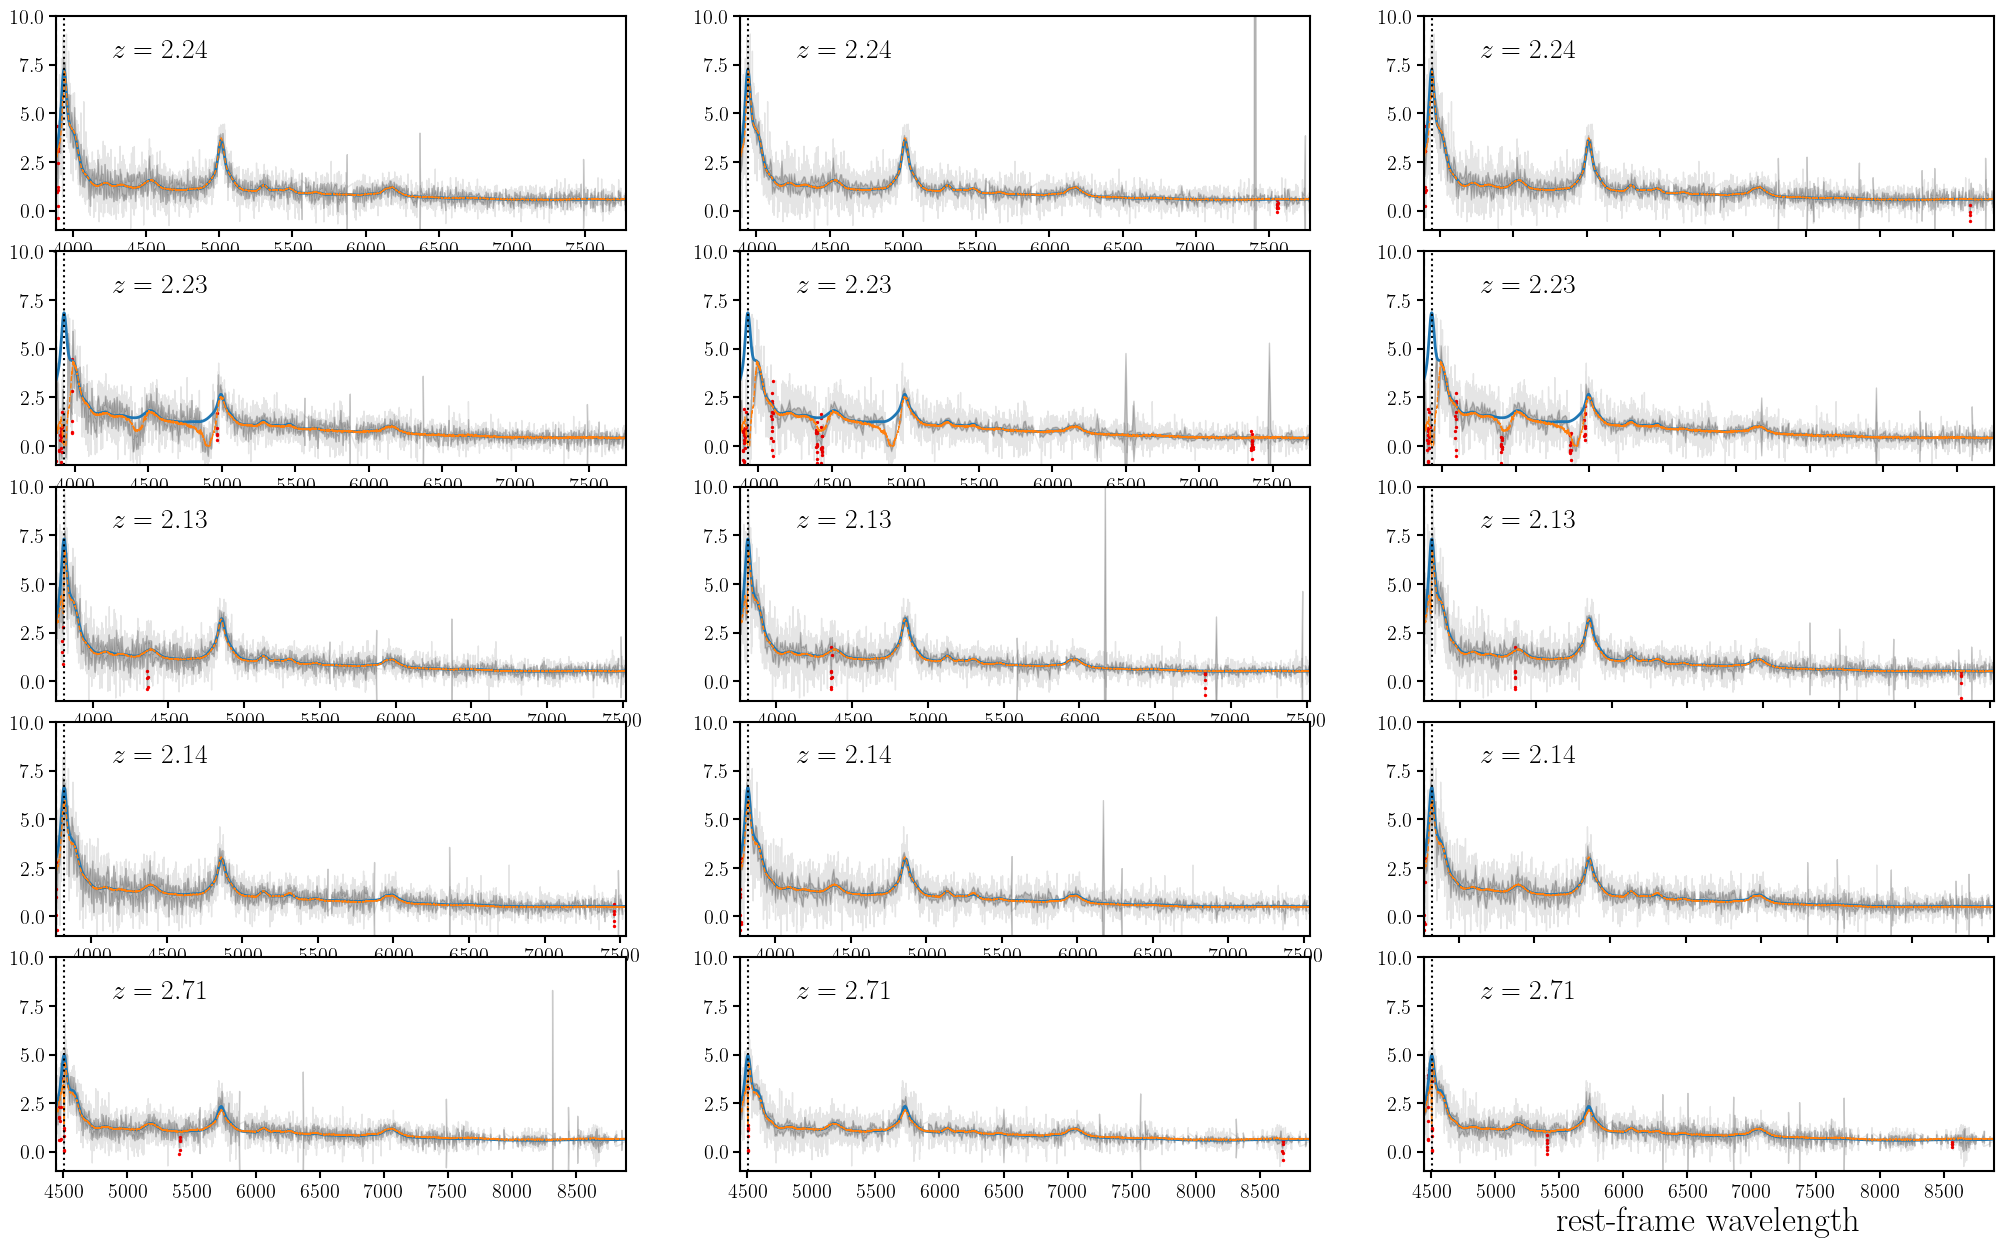

In [234]:
fig = plt.figure(figsize=(25,15))
for ii, igal in enumerate(np.random.choice(np.arange(len(spec))[np.abs(np.array(norm)-1) < 0.1], size=5, replace=False)): 
    sub = fig.add_subplot(5,3,3*ii+1)
    
    sub.plot(models[0].wave_obs[w[igal] > 0], spec[igal][w[igal] > 0], c='k', alpha=0.1, lw=1, label='Observed')    
    sub.plot(np.linspace(3.5e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Cont.')
    
    _w, _f, _i, is_absorb = id_LyA_rebin(
        np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), np.array(z)[igal], 
        np.array(models[0].wave_rest * (1 + z[igal])), np.array(spec_rest[igal]), wmax=1215.67 * (1. + np.array(z)[igal]), 
        method='fixed', verbose=True)
    sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
    sub.scatter(models[0].wave_obs[is_absorb], spec[igal][is_absorb], c='r', s=2)    

    sub.plot(models[0].wave_rest * (1 + z[igal]), spec_rest[igal], color='C1', lw=1, ls='--', label='Reconst.')

    
    sub.axvline(1040. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1200. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1215.67 * (1+z[igal]), linestyle=':', color='k')    

    sub.text(0.1, 0.9, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=20, transform=sub.transAxes)
    sub.set_ylim(-1, 10)
    sub.set_xlim(1200 * (1+z[igal]), 2400. * (1+z[igal]))
    
    
    sub = fig.add_subplot(5,3,3*ii+2)
    
    sub.plot(models[0].wave_obs[w[igal] > 0], spec[igal][w[igal] > 0], c='k', alpha=0.1, lw=1, label='Observed')    
    sub.plot(np.linspace(3.5e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Cont.')
    
    _w, _f, _i, is_absorb = id_LyA_rebin(
        np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), np.array(z)[igal], 
        np.array(models[0].wave_rest * (1 + z[igal])), np.array(spec_rest[igal]), wmax=1215.67 * (1. + np.array(z)[igal]), 
        method='uniform', verbose=True)
    sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
    sub.scatter(models[0].wave_obs[is_absorb], spec[igal][is_absorb], c='r', s=2)    

    sub.plot(models[0].wave_rest * (1 + z[igal]), spec_rest[igal], color='C1', lw=1, ls='--', label='Reconst.')

    
    sub.axvline(1040. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1200. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1215.67 * (1+z[igal]), linestyle=':', color='k')    

    sub.text(0.1, 0.9, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=20, transform=sub.transAxes)
    sub.set_ylim(-1, 10)
    sub.set_xlim(1200 * (1+z[igal]), 2400. * (1+z[igal]))
    
    
    sub = fig.add_subplot(5,3,3*ii+3)
    sub.plot(models[0].wave_obs[w[igal] > 0], spec[igal][w[igal] > 0], c='k', alpha=0.1, lw=1, label='Observed')    
    sub.plot(np.linspace(3.5e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Cont.')

    
    _w, _f, _i, is_absorb = id_LyA_rebin(
        np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), np.array(z)[igal], 
        np.array(models[0].wave_rest * (1 + z[igal])), np.array(spec_rest[igal]), wmax=1215.67 * (1. + np.array(z)[igal]), 
        method='linear', verbose=True)
    sub.fill_between(0.5*(_w[1:] + _w[:-1]), _f-_i**-0.5, _f+_i**-0.5, color='k', alpha=0.2)
    sub.scatter(models[0].wave_obs[is_absorb], spec[igal][is_absorb], c='r', s=2)    


    sub.plot(models[0].wave_rest * (1 + z[igal]), spec_rest[igal], color='C1', lw=1, ls='--', label='Reconst.')

    
    sub.axvline(1040. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1200. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1215.67 * (1+z[igal]), linestyle=':', color='k')    

    sub.text(0.1, 0.9, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=20, transform=sub.transAxes)
    sub.set_ylim(-1, 10)
    sub.set_xlim(1200 * (1+z[igal]), 2400. * (1+z[igal]))
    if ii < 4: sub.set_xticklabels([])
    #if ii == 0: sub.legend(loc='upper right', fontsize=20, handletextpad=0)
sub.set_xlabel("rest-frame wavelength", fontsize=25)
fig.subplots_adjust(hspace=0.1)
plt.show()